## Práctica de selección de variables

- [Análisis de correlaciones](#Análisis-de-correlaciones)
- [Métodos basados en filtros](#Métodos-basados-en-filtros)
- [Métodos basados en wrappers](#Métodos-basados-en-wrappers)
- [PCA: Principal component analysis](#PCA:-Principal-component-analysis)

Importamos todas las librerías que vamos a utilizar durante la práctica.

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
from test_helper import Test

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

Para desarrollar la práctica vamos a trabajar con el dataset [Sonar](http://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29). Este dataset contiene la información de un sonar (energía en diferentes bandas de frecuencia) para distinguir rocas (R) de minas (M). En concreto el dataset tiene 60 variables numéricas como entrada y la información de 208 ejemplos.

En el siguiente código se deben leer los datos del problema Sonar almacenados en el archivo *sonar.csv*. En este caso la variable a predecir se llama *Type*. La debéis pasar a codificación ordinal y al resultado de cada ejemplo restarle uno para que las clases queden codificadas comenzando por 0.

Realiza la lectura de los datos almacenados en el fichero *sonar.csv* y guardar el resultado en una variable llamada sonar. A partir de la variable sonar, generad las variables X (información de entrada) e y (información de salida).

In [2]:
import category_encoders as ce
# Se realiza la lectura del dataset sonar utilizando pandas
    # La primera línea contiene los nombres de las variables
    # header=None se utilizaría en caso de que no existiera una primera línea con los nombres para las variables

sonar = pd.read_csv('sonar.csv')
nombreAtSalida = "Type"

# Generamos los datos de entrada y de salida: nos quedamos con las columnas correspondientes 
# y realizamos la codificación ordinal en caso de la variable de salida
y =  sonar.Type.copy()
X = sonar.drop(['Type'], axis=1).copy()

#Codificacion ordinal
myEncoder = ce.ordinal.OrdinalEncoder()
y = myEncoder.fit_transform(y) - 1

#### Obtención del rendimiento con todas las variables

Para comprobar la calidad de las técnicas de selección de variables, en primer lugar vamos a calcular el rendimiento del clasificador KNN (con la configuración por defecto) si utilizamos todas las variables.

Para ello debéis aplicar el método hold-out para obtener los conjuntos de entrenamiento y de test (70% de datos para entrenar). Obtener el accuracy rate tanto para el conjunto de entrenamiento como para el conjunto de test.

NOTA: Recordar determinar la semilla de Numpy con el valor 12 para garantizar la reproducibilidad de los resultados.

In [3]:
# Se importan las 3 librerías necesarias para resolver el ejercicio
from sklearn import neighbors, metrics, model_selection

# Se fija la semilla de numpy para que la generación aleatoria siempre nos de los mismos números
np.random.seed(12)

# Lllamada a la función train_test_split y guardado del resultado
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y.values.ravel(), train_size=0.7)

# Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
model = neighbors.KNeighborsClassifier()

# Llamada a la función que realiza el aprendizaje del clasificador
model.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos de entrenamiento
prediccionTrain = model.predict(X_train)

# Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrain))

# Llamada a la función que realiza la predicción de los datos de test
prediccionTest = model.predict(X_test)
# Llamada a la función que calcula el porcentaje de acierto para los datos de test
accTest = metrics.accuracy_score(y_test,prediccionTest)*100
print('El rendimiento en test con todas las variables es el {}%'.format(accTest))

El rendimiento en entrenamiento con todas las variables es el 86.20689655172413%
El rendimiento en test con todas las variables es el 68.25396825396825%


In [4]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(round(accTrain, 2), 86.21, 'Valor de accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 68.25, 'Valor de accuracy en test incorrecto')

1 test passed.
1 test passed.


## Análisis de correlaciones

### Visualización de la matriz de correlaciones

En este apartado vamos a calcular y mostrar visualmente la matriz de correlaciones entre todas las variables de entrada. Para ello vamos a utilizar la librería Pandas y, en concreto, la función [*corr*](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html)

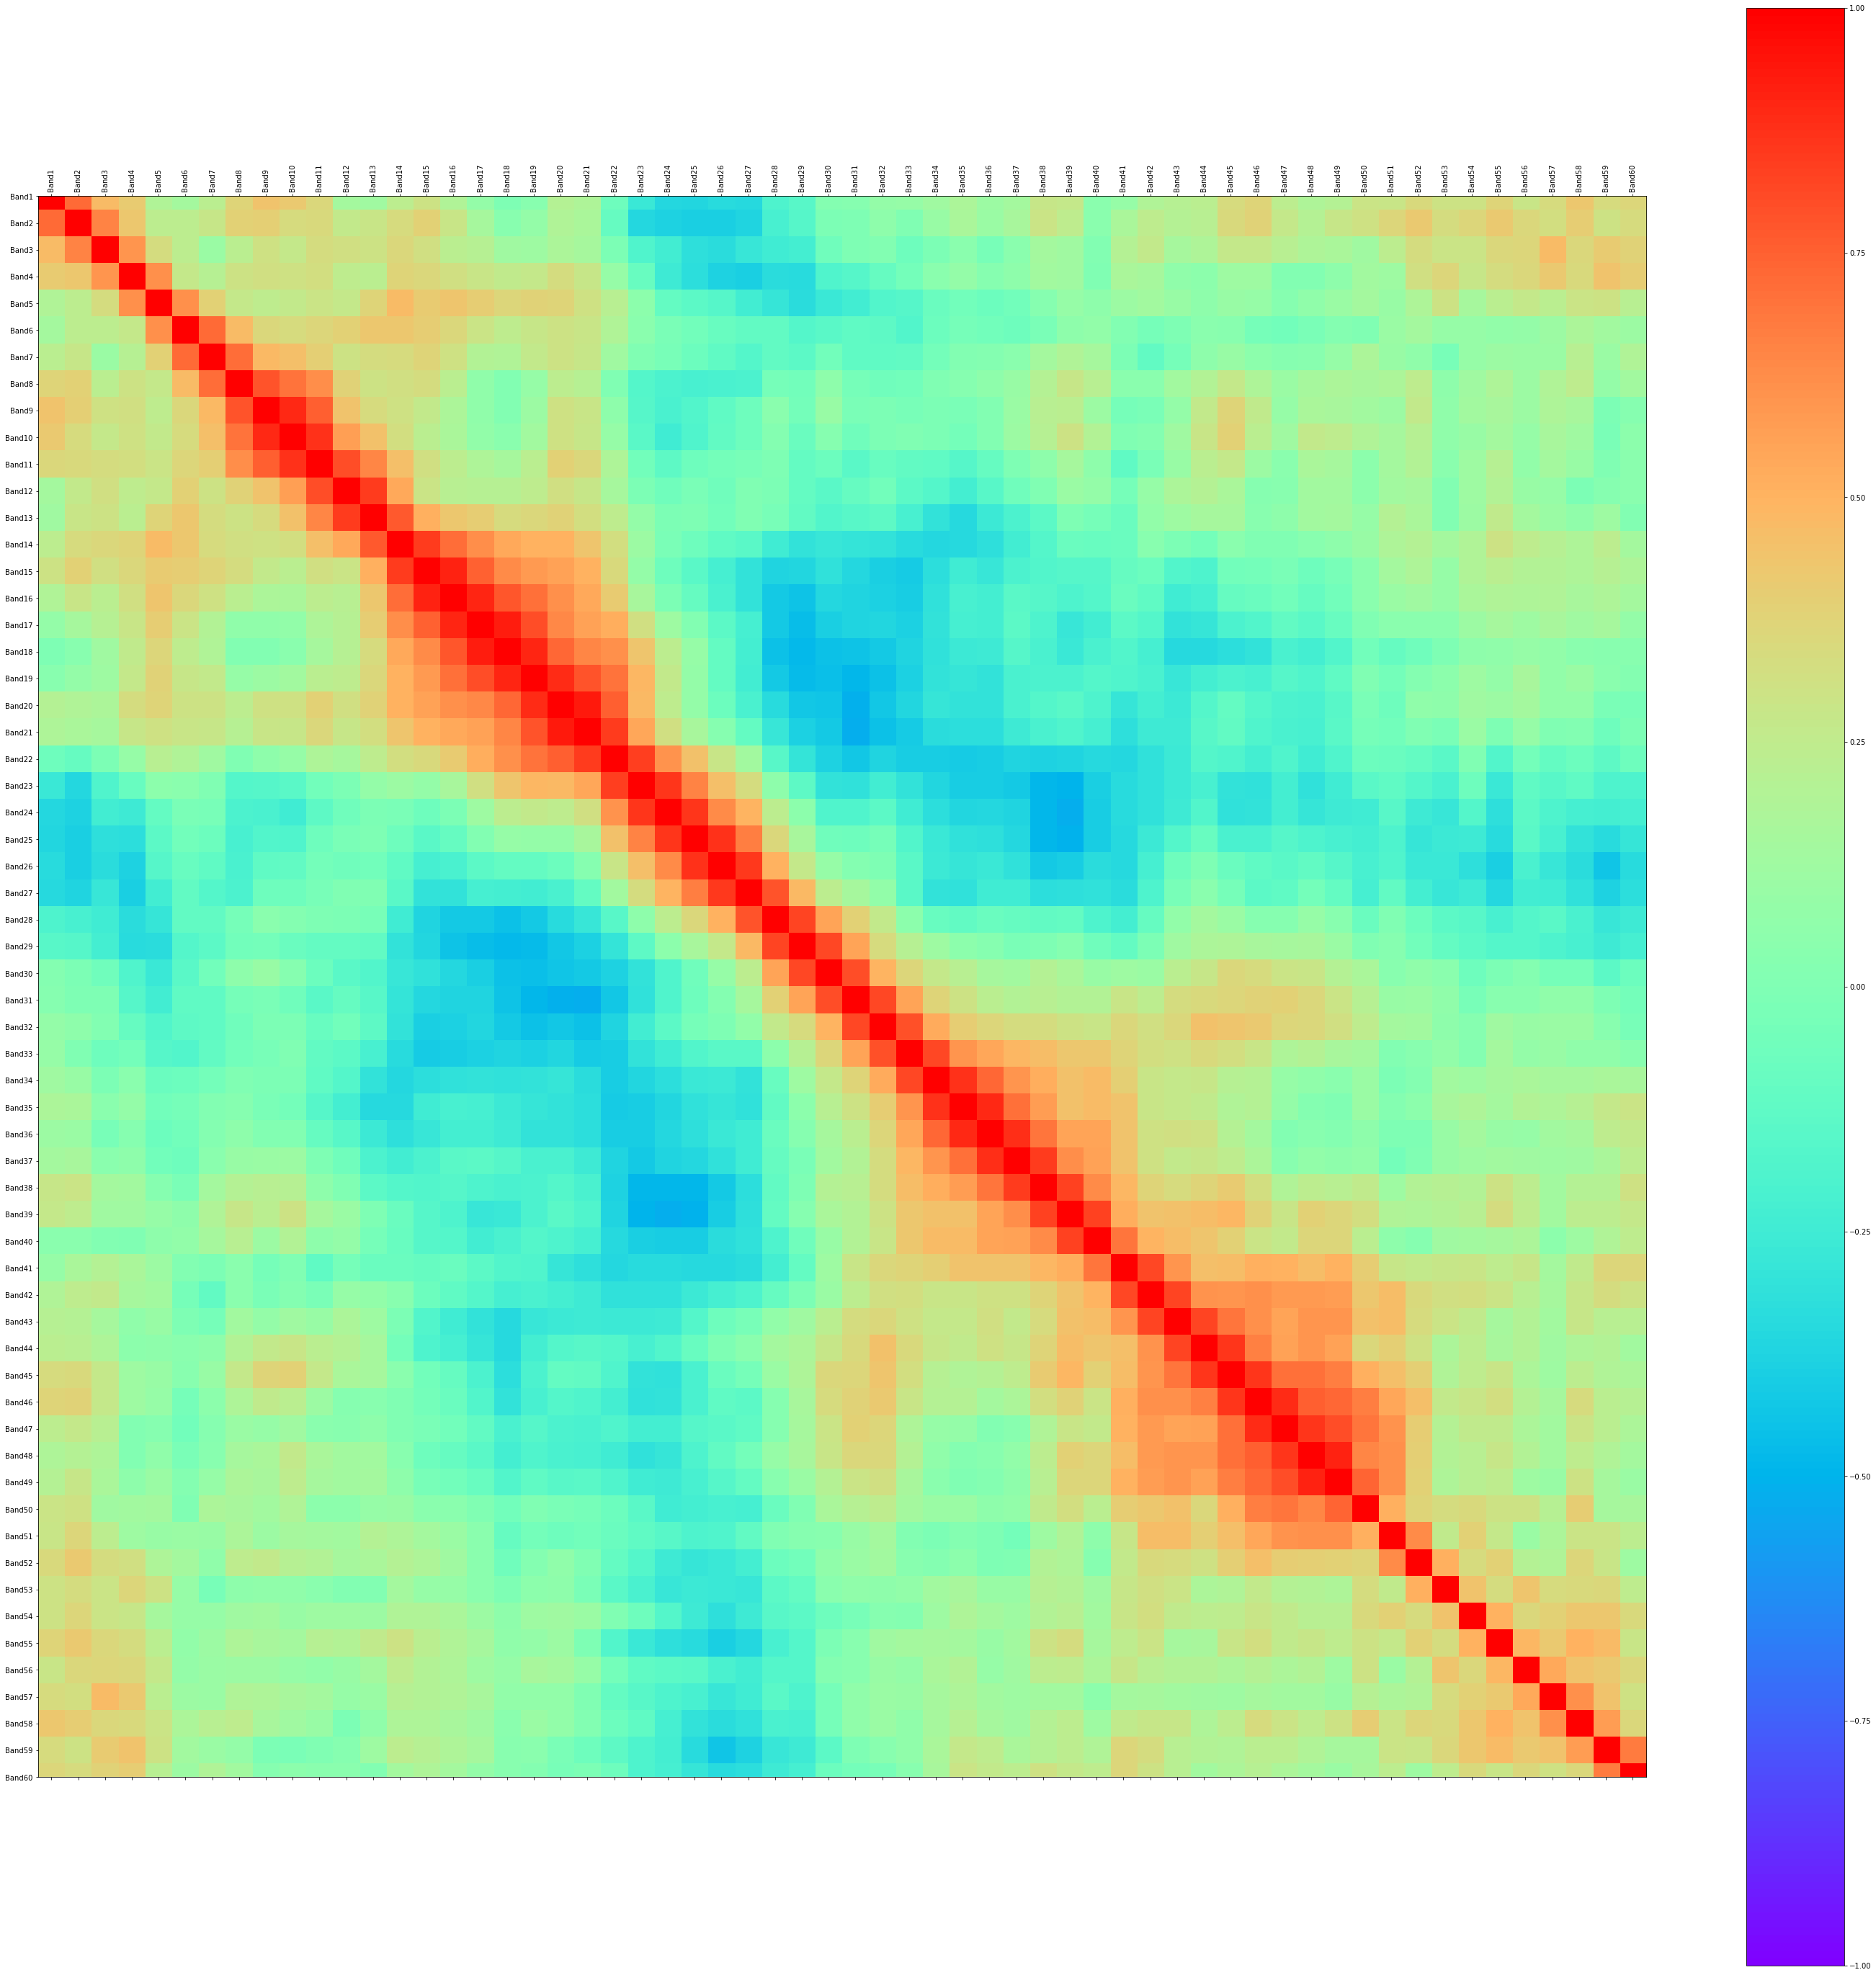

In [5]:
import matplotlib.pyplot as plt

# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = X_train.corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# Añadimos los nombres de las variables en la figura
names = X_train.columns
ax.set_xticklabels(names, rotation='90')
ax.set_yticklabels(names)
plt.show()

En este caso no se observa muy bien (puesto que la matriz es muy grande) que la matriz es simétrica (matriz triangular superior e inferior iguales). Además, se observa que la correlación entre una variable y ella misma es perfecta (diagonal con unos: rojo).

A continuación, vamos a tratar de hacer las correlaciones entre las variables de entrada para descartar aquellas que estén altamente correlacionadas entre ellas y que, por tanto, no aporten información extra. Para obtener las variables correlacionadas vamos seleccionar las que tenga un valor de correlación mayor que un umbral (inicialmente lo asignamos a 0.8).

In [6]:
# Creamos la matriz de correlación en valor absoluto: función abs (da igual se se correlacionan positiva o negativamente)
corr_matrix = abs(correlaciones)

# Seleccionamos el triángulo superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Umbral deseado para determinar variables correlacionadas
umbral = 0.8
# Obtenemos los índices de aquellas variables con correlación mayor al umbral deseado
indices_variables_a_eliminar = [i for i,column in enumerate(upper.columns) if any(upper[column] > umbral)]

# Creamos una copia de los datos de train para poder seguir trabajando con ellos posteriormente
datos_train = X_train.copy()
# Eliminamos las variables con alta correlación con algunda de las variables de entrada 
datos_train = datos_train.drop(datos_train.columns[indices_variables_a_eliminar], axis=1)
# Mostramos las dimensiones del problema tras reducir las variables redundantes
print(datos_train.shape)

datos_test = X_test.copy()
datos_test = datos_test.drop(datos_test.columns[indices_variables_a_eliminar], axis=1)

(145, 24)


In [7]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(datos_train.shape[1], 24, 'Dimensiones del problemas tras la seleccion incorrectas')

1 test passed.


Finalmente obtenemos el rendimiento de KNN con las variables seleccionadas. Recordad que con todas las variables el rendimiento en train es del 86.21% y en test del 68.25%.

In [8]:
# Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
knn = neighbors.KNeighborsClassifier()

# Llamada a la función que realiza el aprendizaje del clasificador con los datos tras reducir su dimensionalidad
knn.fit(datos_train,y_train)

# Llamada a la función que realiza la predicción de los datos de entrenamiento (tras reducir su dimensionalidad)
prediccionTrain = knn.predict(datos_train)

# Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento 
accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
print('El rendimiento en entrenamiento con las variables no redundantes es el {}%'.format(accTrain))

# Llamada a la función que realiza la predicción de los datos de test (tras reducir su dimensionalidad)
prediccionTest = knn.predict(datos_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos de test
accTest = metrics.accuracy_score(y_test,prediccionTest)*100
print('El rendimiento en test con las variables no redundantes  es el {}%'.format(accTest))

El rendimiento en entrenamiento con las variables no redundantes es el 85.51724137931035%
El rendimiento en test con las variables no redundantes  es el 71.42857142857143%


In [9]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(accTrain, 2), 85.52, 'Rendimiento en train incorrecto')
Test.assertEquals(round(accTest, 2), 71.43, 'Rendimiento en test incorrecto')

1 test passed.
1 test passed.


A continuación debéis obtener el rendimiento de la eliminación de variables correlacionadas al variar el umbral. Debéis probar los valores 0.6, 0.7, 0.8 y 0.9 como posibles umbrales.

In [10]:
# Listas para almacenar el número de variables no correlacionadas entre ellas y los resultados de train y test
listaNumVarSel = []
listaAccTrain = []
listaAccTest = []
for umbral in [0.6,0.7,0.8,0.9]:
    
    # Obtenemos los índices de aquellas variables con correlación mayor al umbral deseado
    indices_variables_a_eliminar = [i for i,column in enumerate(upper.columns) if any(upper[column] > umbral)]
    # Creamos una copia de los datos de train para poder seguir trabajando con ellos posteriormente
    datos_train = X_train.copy()
    # Eliminamos las variables con alta correlación con algunda de las variables de entrada 
    datos_train = datos_train.drop(datos_train.columns[indices_variables_a_eliminar], axis=1)
    # Aplicamos la seleccion a los datos de test
    datos_test = X_test.copy()
    datos_test = datos_test.drop(datos_test.columns[indices_variables_a_eliminar], axis=1)
    
    
    listaNumVarSel.append(datos_train.shape[1])
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador con los datos tras reducir su dimensionalidad
    knn.fit(datos_train,y_train)

    # Llamada a la función que realiza la predicción de los datos de entrenamiento (tras reducir su dimensionalidad)
    prediccionTrain = knn.predict(datos_train)

    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento 
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    listaAccTrain.append(accTrain)

    # Llamada a la función que realiza la predicción de los datos de test (tras reducir su dimensionalidad)
    prediccionTest = knn.predict(datos_test)

    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100
    listaAccTest.append(accTest)

In [11]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [72.41, 75.17, 85.52, 86.21], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [60.32, 58.73, 71.43, 66.67], 'Valores de accuracy en test incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaNumVarSel)), [8, 16, 24, 55], 'Numero de variables seleccionadas incorrecto')

1 test passed.
1 test passed.
1 test passed.


### Métodos basados en filtros

La librería scikit-learn nos ofrece una librería para realizar la selección variables. Esta librería se llama [*feature_selection*](http://scikit-learn.org/stable/modules/feature_selection.html).

Para poder utilizar todas las funcionalidades primero debemos importarla.

In [12]:
# Se importa la librería de selección de variables
from sklearn import feature_selection

En primer lugar vamos a aplicar técnicas basadas en filtros uni-variable. Los filtros uni-variables aplican una medida (habitualmente estadística) que determina la calidad de las variables individuales. Scikit-learn provee tres métricas de calidad de las variables para resolver problemas de clasificación:
* Chi cuadrado: función [*chi2*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2)
* ANOVA: función [*f_classif*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)
* Información mutua: función [*mutual_info_classif*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

Para resolver problemas de regresión ofrece
* Correlación mutua: función [*f_regression*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)
* Información mutua: función [*mutual_info_regression*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression)

En esta práctica vamos a utilizar solamente las de clasificación. 

Una vez conocida la calidad de cada variable se deben escoger las mejores. Para ello vimos en las clases teóricas que había varias opciones. La librería Scikit-learn ofrece dos de estas técnicas en forma de clases (con sus campos y sus métodos):
* Elegir las k mejores con la clase [*SelectKBest*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)
    
    SelectKBest(score_func=funcionCalidad, k=valorK)
    
    
* Elegir las variables en base al percentil (el % de las variables) con la clase [*SelectPercentile*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile)
    
    SelectPercentile(score_func=funcionCalidad, percentile=porcentajeVariables)

En ambas clases, elegir las k mejores o las que estén en el percentil deseado, en la llamada al constructor se debe especificar:
* La medida de calidad (funcionCalidad) de las variables. Es decir, cualquiera de las 3 funciones comentadas anteriormente
    * chi2
    * f_classif
    * mutual_info_classif
* El valor del parámetro k (valorK) para el método de las k mejores o el valor del percentil (porcentajeVariables) para el método de selección en base al percentil.

En ambas clases disponemos de los mismos métodos para realizar la selección de las variables:
* fit: Recibe como parámetro de entrada los datos de entrada (X) y de salida (Y). Esta función aplica la medida de calidad pasada como parámetro de entrada (funcionCalidad) sobre cada variable y establece la importancia de cada una de ellas.
* transform: Recibe como parámetro de entrada los datos de entrada (X). Esta función devuelve los datos de entrada con la selección de variables realizada (X'). Es decir, X' tendrá el mismo número de ejemplos pero menor número de variables (solamente las seleccionadas).
* fit_transform: Recibe como parámetro de entrada los datos de entrada (X) y de salida (Y). Esta función aplica secuencialmente las dos funciones anteriores.
* get_support: esta función devuelve un array de booleanos con tantos elementos como variables. En cada posición tendrá True si la variable asociada ha sido seleccionada y False en caso contrario.
* inverse_transform: Recibe como parámetro de entrada los datos de entrada con la selección de variables realizada (X'). Esta función deshace la selección de variables, es decir, devuelve el conjunto de datos original (X).

Utiliza el método de selección de las k mejores variables seleccionando las 10, 20 y 30 mejores variables aplicando Chi cuadrado como medida de calidad de las variables. Para ello se debe realizar el siguiente proceso:
* Realizar la selección de variables utilizando los ejemplos de entrenamiento obtenidos anteriormente.
* Utilizar el clasificador KNN con la configuración por defecto para obtener el accuracy rate con los ejemplos de entrenamiento y de test.
* Compara los resultados de las diferentes selecciones realizadas y con respecto a los resultados obtenidos al utilizar todas las variables.

In [13]:
# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
for numVar in [10,20,30]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = feature_selection.SelectKBest(score_func=feature_selection.chi2,k=numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100

    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Seleccionando las 10 mejores variables se obtiene un accuracy del 86.89655172413792% en entrenamiento
Seleccionando las 10 mejores variables se obtiene un accuracy del 74.60317460317461% en test
Seleccionando las 20 mejores variables se obtiene un accuracy del 88.96551724137932% en entrenamiento
Seleccionando las 20 mejores variables se obtiene un accuracy del 76.19047619047619% en test
Seleccionando las 30 mejores variables se obtiene un accuracy del 86.20689655172413% en entrenamiento
Seleccionando las 30 mejores variables se obtiene un accuracy del 76.19047619047619% en test


In [14]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [86.90, 88.97, 86.21], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [74.60, 76.19, 76.19], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


Repetir el ejercicio anterior pero utilizando ANOVA para medir la calidad de las variables.

In [15]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
for numVar in [10,20,30]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = feature_selection.SelectKBest(score_func=feature_selection.f_classif,k=numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100

    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Seleccionando las 10 mejores variables se obtiene un accuracy del 87.58620689655172% en entrenamiento
Seleccionando las 10 mejores variables se obtiene un accuracy del 76.19047619047619% en test
Seleccionando las 20 mejores variables se obtiene un accuracy del 88.27586206896552% en entrenamiento
Seleccionando las 20 mejores variables se obtiene un accuracy del 84.12698412698413% en test
Seleccionando las 30 mejores variables se obtiene un accuracy del 87.58620689655172% en entrenamiento
Seleccionando las 30 mejores variables se obtiene un accuracy del 82.53968253968253% en test


In [16]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [87.59, 88.28,87.59], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [76.19, 84.13,82.54], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


Repetir el ejercicio anterior pero utilizando el método del percentil (10%, 20% y 30%) y Chi cuadrado para medir la calidad de las variables.

In [17]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
for numVar in [10,20,30]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = feature_selection.SelectPercentile(score_func=feature_selection.chi2,percentile=numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100

    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Seleccionando las 10 mejores variables se obtiene un accuracy del 82.75862068965517% en entrenamiento
Seleccionando las 10 mejores variables se obtiene un accuracy del 79.36507936507937% en test
Seleccionando las 20 mejores variables se obtiene un accuracy del 87.58620689655172% en entrenamiento
Seleccionando las 20 mejores variables se obtiene un accuracy del 77.77777777777779% en test
Seleccionando las 30 mejores variables se obtiene un accuracy del 86.20689655172413% en entrenamiento
Seleccionando las 30 mejores variables se obtiene un accuracy del 82.53968253968253% en test


In [18]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [82.76, 87.59,86.21], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [79.37, 77.78,82.54], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


Repetir el ejercicio anterior pero utilizando ANOVA para medir la calidad de las variables.

In [19]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
for numVar in [10,20,30]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = feature_selection.SelectPercentile(score_func=feature_selection.f_classif,percentile=numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100

    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Seleccionando las 10 mejores variables se obtiene un accuracy del 80.6896551724138% en entrenamiento
Seleccionando las 10 mejores variables se obtiene un accuracy del 82.53968253968253% en test
Seleccionando las 20 mejores variables se obtiene un accuracy del 83.44827586206897% en entrenamiento
Seleccionando las 20 mejores variables se obtiene un accuracy del 73.01587301587301% en test
Seleccionando las 30 mejores variables se obtiene un accuracy del 86.89655172413792% en entrenamiento
Seleccionando las 30 mejores variables se obtiene un accuracy del 88.88888888888889% en test


In [20]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [80.69, 83.45,86.90], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [82.54, 73.02,88.89], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


A continuación vamos a imitar el funcionamiento de Scikit-learn pero implementando dos técnicas de filtro vistas en clase de teoría: t-test y Relief. Para ello, Scikit-learn nos ofrece la clase llamada [*TransformerMixin*](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) que permite implementar una nueva clase para realizar procesos de pre-procesamento con sus respectivos constructores y los métodos *fit* y *predict* para imitar el funcionamiento de todo el resto de clases de Scikit-learn.

Ambas técnicas van a tener el mismo funcionamiento. Se debe definir una clase para cada una de ellas que:
* Su constructor reciba
    * El tipo de selección de variables a realizar, que será un string con *Kbest* (valor por defecto) o *percentil* como posibles valores.
    * El valor de K (valor por defecto *None*) en el caso de realizar la selección de las K mejores variables.
    * El valor del percentil (valor por defecto *None*) en el caso de realizar la selección de las mejores variables en base al percentil.
* El método *fit* realice las operaciones necesarias para obtener la calidad de las variables de entrada del problema. Para ello va debe recibir como parámetros de entrada el conjunto de ejemplos con el que aprender la calidad de las variables (X_train) y las salidas de las mismas (y_train). Cada clase modificará la propiedad adecuada (llamada t, self.t, en el caso de t-test y w, self.w, en el caso de Relief). Como salida deben devolver el propio objeto de la clase (self).
* El método *transform* debe realizar la transformación del DataFrame pasado como parámetro de entrada (X). Para ello, se obtendrán las mejores variables en función del método de selección de variables especificado y se devolverá el DataFrame modificado.

Implementad en primer lugar la clase correspondiente a la técnica t-test. Recordad que las restas se deben realizar en valor absoluto.

NOTA: para simplificar la implementación vamos a asumir que la varianza es diferente para todas las variables.

In [21]:
# Importamos la clase TransformerMixin
from sklearn.base import TransformerMixin

class t_test(TransformerMixin):

    def __init__(self, tipoSeleccion='Kbest', K=None, percentil=None):
        self.tipoSeleccion = tipoSeleccion
        self.K = K
        self.percentil = percentil
        
    def fit(self, X_train, y_train):
        # Variables para almacenar el número de ejemplos, las medias, desviaciones estándar y variazas
            # de los ejemplos según su clase (clase 0: C0 y clase 1: C1)
        N0 = y_train[y_train==0].size
        N1 = y_train[y_train==1].size
        mediasC0 = X_train[y_train==0].mean()
        mediasC1 = X_train[y_train==1].mean()
        stdsC0 = X_train[y_train==0].std()
        stdsC1 = X_train[y_train==1].std()
        varsC0 = X_train[y_train==0].var()
        varsC1 = X_train[y_train==1].var()
        # Propiedad para almacenar el valor t de cada variable
        self.t =  np.abs(mediasC0-mediasC1)/np.sqrt(np.abs((stdsC0/N0)-(stdsC1/N1)))
        return self

    def transform(self, X):
        # Variable para almacenar los índices de las variables ordenadas de acuerdo al valor t
        indices = np.argsort(-self.t)
        # Variable para almacenar True en caso de que la variable se seleccione y False en caso contrario
            # de aceurdo al tipo de selección especificdo en el constructor
        booleanos = np.zeros(X.shape[1],).astype('bool')
        if self.tipoSeleccion=='Kbest':
            booleanos[indices[0:self.K]] = True
        elif self.tipoSeleccion=='percentil':
            booleanos[indices[0:(int)(X.shape[1]*self.percentil/100)]] = True        
        return X.iloc[:,booleanos]
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
    # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Aplicad la técnica t-test con el método de selección de las K mejores variables y obtened los resultados en las mismas condiciones que para el resto de filtros utilizados en esta práctica.

In [22]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
for numVar in [10,20,30]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = t_test(tipoSeleccion='Kbest',K=numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn = knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Seleccionando las 10 mejores variables se obtiene un accuracy del 87.58620689655172% en entrenamiento
Seleccionando las 10 mejores variables se obtiene un accuracy del 77.77777777777779% en test
Seleccionando las 20 mejores variables se obtiene un accuracy del 84.13793103448276% en entrenamiento
Seleccionando las 20 mejores variables se obtiene un accuracy del 79.36507936507937% en test
Seleccionando las 30 mejores variables se obtiene un accuracy del 84.82758620689656% en entrenamiento
Seleccionando las 30 mejores variables se obtiene un accuracy del 79.36507936507937% en test


In [23]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [87.59, 84.14, 84.83], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [77.78, 79.37, 79.37], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


Aplicad la técnica t-test con el método de selección basado en el percentil y obtened los resultados en las mismas condiciones que para el resto de filtros utilizados en esta práctica.

In [24]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
for numVar in [10,20,30]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = t_test(tipoSeleccion='percentil',percentil=numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
    knn = neighbors.KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn = knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Seleccionando las 10 mejores variables se obtiene un accuracy del 82.75862068965517% en entrenamiento
Seleccionando las 10 mejores variables se obtiene un accuracy del 79.36507936507937% en test
Seleccionando las 20 mejores variables se obtiene un accuracy del 86.20689655172413% en entrenamiento
Seleccionando las 20 mejores variables se obtiene un accuracy del 73.01587301587301% en test
Seleccionando las 30 mejores variables se obtiene un accuracy del 84.82758620689656% en entrenamiento
Seleccionando las 30 mejores variables se obtiene un accuracy del 74.60317460317461% en test


In [25]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [82.76, 86.21, 84.83], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [79.37, 73.02, 74.6], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


Implementad en primer lugar la clase correspondiente a la técnica Relief. 

Para facilitar la tarea se importa la librería *neighbors* puesto que se recomienda el uso del clasificador de los K vecinos más cercanos para obtener los ejemplos más cercanos de la clase del ejemplo (NC) y de la otra clase (NF). En concreto, se deberán crear dos KNNs: 
* Uno entrenado con los ejemplos de la clase del ejemplo (con k=2). No olvidéis que el vecino más cercano de la misma clase que el ejemplo aleatorio será el propio ejemplo aleatorio y, por tanto, el vecino más cercano debe ser el segundo ejemplo más cercano (por eso se entrena este KNN con k=2).
* El otro con los ejemplos de la otra clase (con k=1). 

Además, se debe utilizar:
* Para obtener los vecinos del ejemplo seleccionado se debe utilizar el método [*kneighbors*](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors) de la clase *KNeighborsClassifier*. 
* La distancia de Hamming para actualizar los pesos (valor absoluto de la resta). 
* El valor 12 como semilla de Numpy.
* Generad el número aleatorio para elegir el ejemplo con el que trabajar en cada iteración con la función [*randint*](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) de *Numpy.random*.

In [26]:
y_train[5]
X

     Band1  Band2  Band3  Band4  Band5  Band6  Band7  Band8  Band9  Band10  \
0    0.020  0.037  0.043  0.021  0.095  0.099  0.154  0.160  0.311   0.211   
1    0.045  0.052  0.084  0.069  0.118  0.258  0.216  0.348  0.334   0.287   
2    0.026  0.058  0.110  0.108  0.097  0.228  0.243  0.377  0.560   0.619   
3    0.010  0.017  0.062  0.020  0.020  0.037  0.110  0.128  0.060   0.126   
4    0.076  0.067  0.048  0.039  0.059  0.065  0.121  0.247  0.356   0.446   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
203  0.019  0.035  0.017  0.018  0.039  0.163  0.203  0.169  0.233   0.268   
204  0.032  0.010  0.030  0.056  0.076  0.096  0.099  0.102  0.103   0.215   
205  0.052  0.044  0.018  0.029  0.035  0.117  0.126  0.118  0.126   0.253   
206  0.030  0.035  0.049  0.061  0.017  0.135  0.146  0.112  0.194   0.235   
207  0.026  0.036  0.014  0.027  0.021  0.034  0.066  0.140  0.184   0.235   

     Band11  Band12  Band13  Band14  Band15  Band16  Band17  Ba

In [27]:
from sklearn import neighbors

class relief(TransformerMixin):

    def __init__(self, tipoSeleccion='Kbest', K=None, percentil=None):
        self.tipoSeleccion = tipoSeleccion
        self.K = K
        self.percentil = percentil
        
    def fit(self, X_train, y_train):
        np.random.seed(12)
        # Propiedad para almacenar el valor w de cada variable
        self.w = np.zeros(len(X_train.columns),)
        # Bucle ierativo para trabajar con el ejemplo aleatorio elegido en cada iteración
        for i in range(X_train.shape[0]):
            # índice aleatorio que será el ejemplo con el que trabajemos
            indice =  np.random.randint(X_train.shape[0], size=1)
            # Nos quedamos con el ejemplo aleatorio y su clase: el ejemplo pasarlo a array de Numpy (.values.reshape(-1,1))
            ejemplo = X_train.iloc[indice].values
            claseEjemplo = y_train[indice]
            # Creación y entrenamiento del clasificador KNN con los ejemplos de la misma clase que el elegido en la iteración
            knnClase = neighbors.KNeighborsClassifier()
            knnClase = knn.fit(X_train[y_train == claseEjemplo],y_train[y_train == claseEjemplo])
            # Creación y entrenamiento del clasificador KNN con los ejemplos de la otra clase que la del elegido en la iteración
            knnNoClase = neighbors.KNeighborsClassifier()
            knnNoClase = knn.fit(X_train[y_train != claseEjemplo],y_train[y_train != claseEjemplo])
            # Nos quedamos con el índice del ejemplo más cercano de clase diferente (NF) y de la misma clase (NC) que el ejemplo de la iteración
            _,NF = knnNoClase.kneighbors(ejemplo)
            NF = NF[0][0]
            _,NC = knnClase.kneighbors(ejemplo)
            NC = NC[0][1]
            # Cálculo de las distancias para actualizar los pesos (self.w) de cada variable
            distEjNF,_ = knnClase.kneighbors(e)
            distEjNC,_ = knnNoClase.kneighbors(e)
            self.w +=  np.abs((ejemplo.ravel() - X_train[y_train == claseEjemplo].values)) / X_train.shape[0]
            self.w -=  np.abs((ejemplo.ravel() - X_train[y_train != claseEjemplo].values)) / X_train.shape[0]
        return self

    def transform(self, X):
        # Métoddo que realiza la selección de las variables y devuelve el DataFrame modificado a partir del pasado como entrada (X)
        # <RELLENAR>
        
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
    # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

IndentationError: expected an indented block (<ipython-input-27-4f996e16ddb8>, line 45)

Aplicad la técnica Relief con el método de selección de las K mejores variables y obtened los resultados en las mismas condiciones que para el resto de filtros utilizados en esta práctica.

In [ ]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
# <RELLENAR>

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [89.66, 86.21, 85.52], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [79.37, 77.78, 76.19], 'Valores de accuracy en test incorrectos')

Aplicad la técnica Relief con el método de selección basado en el percentil y obtened los resultados en las mismas condiciones que para el resto de filtros utilizados en esta práctica.

In [ ]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
# <RELLENAR>

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [88.28, 84.14, 86.90], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [80.95, 82.54, 77.78], 'Valores de accuracy en test incorrectos')

### Método basados en wrappers

La librería Scikit-learn también nos ofrece una clase para poder implementar un Wrapper. Esta clase está dentro de la librería feature_selection y se llama [*RFE*](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

Esta clase corresponde al método Sequential Backward Selecion (SBS) explicado en clase de teoría. Es decir, es el método en el que se comienza con todas las variables del problema e iterativamente se va eliminando la peor variable de las que queden. En el caso de la implementación de esta clase lo que se hace es lo siguiente:
* Se aprende un clasificador (pasado como parámetro de entrada: clasificador) con todas las variables y se asignan pesos a cada una de las variables.
* Se elimina(n) variable(s) (el número de variables a eliminar se pasa como parámetro de entrada: numeroVariablesEliminarEnPaso) cuyos pesos en valor absoluto sean los menores.
* Luego se vuelve a entrenar con las variables que queden y se vuelven a calcular los pesos de dichas variables.
* Este proceso se repite hasta que se alcance el número de variables a mantener (pasado como parámetro de entrada: numeroVariablesMantener)

La llamada al constructor de la clase es la siguiente:

    RFE(clasificador, n_features_to_select=numeroVariablesMantener, step=numeroVariablesEliminarEnPaso)
    
Esta clase tiene varios métodos, entre ellos los mismos que se han explicado para los filtros uni-variables utilizados en la primera parte de la práctica:
* fit: Recibe como parámetro de entrada los datos de entrada (X) y de salida (Y). Esta función aplica la medida de calidad pasada como parámetro de entrada (funcionCalidad) sobre cada variable y establece la importancia de cada una de ellas.
* transform: Recibe como parámetro de entrada los datos de entrada (X). Esta función devuelve los datos de entrada con la selección de variables realizada (X'). Es decir, X' tendrá el mismo número de ejemplos pero menor número de variables (solamente las seleccionadas).
* fit_transform: Recibe como parámetro de entrada los datos de entrada (X) y de salida (Y). Esta función aplica secuencialmente las dos funciones anteriores.
* get_support: esta función devuelve un array de booleanos con tantos elementos como variables. En cada posición tendrá True si la variable asociada ha sido seleccionada y False en caso contrario.
* inverse_transform: Recibe como parámetro de entrada los datos de entrada con la selección de variables realizada (X'). Esta función deshace la selección de variables, es decir, devuelve el conjunto de datos original (X).

NOTA: el clasificador utilizado en el wrapper (evaluación de la importancia de las variables) tiene que actualizar el atributo coef_ de su clase correspondiente. En caso de que no lo haga no se puede utilizar como clasificador para la eliminación secuencial de variables.

Utiliza la clase RFE para realizar la selección de variables en el problema de Sonar. Para ello debes utilizar lo siguiente
* Como clasificador del Wrapper utiliza la [regresión logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) con la configuración por defecto excepto el *solver* que debe ser 'liblinear'.
    * Hay que importar la librería *linear_model* y utilizar la clase LogisticRegression: *linear_model.LogisticRegression()*
* Eliminar una variable cada vez (*step=1*)
* Probar diferentes valores de variables a mantener: 10, 20 y 30

Evalúa la calidad de la selección realizada utilizando la regresión logística con la configuración por defecto excepto el híper-parámetro mencionado anteriormente.

In [28]:
from sklearn import linear_model

# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
for variablesMantener in [10,20,30]:
    # Se llama al constructor que realiza la selección de variables en base a la eliminación secuencial de variables
        # Utiliza los parámetros adecuados
    tecnicaSeleccion = feature_selection.RFE(linear_model.LogisticRegression(solver = 'liblinear'),n_features_to_select=variablesMantener,step=1)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para la regresión logística por lo que hay que llamar al constructor de dicho clasificador con la configuración apropiada
    RL = linear_model.LogisticRegression(solver = 'liblinear')
    # Llamada a la función que realiza el aprendizaje del clasificador
    RL.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = RL.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    listaAccTrain.append(accTrain)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(variablesMantener, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = RL.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = metrics.accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    listaAccTest.append(accTest)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(variablesMantener, accTest))

Manteniendo 10 variables se obtiene un accuracy del 76.55172413793103% en entrenamiento
Manteniendo 10 variables se obtiene un accuracy del 80.95238095238095% en test
Manteniendo 20 variables se obtiene un accuracy del 78.62068965517241% en entrenamiento
Manteniendo 20 variables se obtiene un accuracy del 85.71428571428571% en test
Manteniendo 30 variables se obtiene un accuracy del 78.62068965517241% en entrenamiento
Manteniendo 30 variables se obtiene un accuracy del 88.88888888888889% en test


In [29]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [76.55, 78.62, 78.62], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [80.95, 85.71, 88.89], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.


### PCA: Principal component analysis

Una técnica muy habitual a la hora de realizar reducción de datos por medio de transformaciones de variables es el análisis de las componentes principales (PCA, de sus siglas en inglés). Scikit-learn nos ofrece dicha técnica implementada en la clase [*PCA*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) de la librería *decomposition*. El constructor con los parámetros que vamos a utilizar en esta práctica es el siguiente:
    
    sklearn.decomposition.PCA(n_components: numCom, svd_solver='full')
    
El parámetro n_components puede tener diferentes valores al utilizar *svd_solver='full'*:
* Si *numCom* es un valor entero especifica el númerto de componentes principales a mantener.
* Si *numCom* es un valor real entre 0 y 1 especifica el porcentaje de la varianza que representan los  componentes principales seleccionados. 

El porcentaje de varianza que representa cada componente principal se puede encontrar en el atributo *explained_variance_ratio_* de la clase PCA. El número de componentes principales seleccionados se puede obtener en el atributo *n_components_* de la clase PCA.

Al igual que el resto de técnicas de preprocesamiento, para ejecutar PCA se debe llamar al constructor de la clase PCA, luego entrenarlo, método *fit*, con los ejemplos de entrenamiento y finalmente el objeto entrenado se puede utilizar para transformar ejemplos a la nueva base mediante el método *transform*.

En la siguiente celda debéis ejecutar PCA utilizando tantos componentes principales como sean necesarios para mantener el 95% de la varianza. Debéis entrenar PCA con los datos de entrenamiento obtenidos al comienzo de la práctica y transformar tanto los datos de entrenamiento como los de test. Dichos datos transformados serán utilizados para obtener el rendimiento de KNN tanto en entrenamiento como en test con su configuración por defecto.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train,y_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

knn = neighbors.KNeighborsClassifier()

knn.fit(X_train_transformed,y_train)

prediccionTrain = knn.predict(X_train_transformed)
prediccionTest = knn.predict(X_test_transformed)

accTrain = metrics.accuracy_score(y_train,prediccionTrain) * 100
accTest = metrics.accuracy_score(y_test,prediccionTest) * 100

In [31]:
Test.assertEquals(round(accTrain, 2), 86.90, 'Accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 71.43, 'Accuracy en test incorrecto')

1 test passed.
1 test passed.


Algo interesante de PCA es que podemos analizar la influencia del número de componentes principales utilizados. Scikit-learn nos devuelve los componentes principales ordenados por importancia (varianza de información que representan). Por este motivo, el primer componente principal será el más importante, luego el segundo, etc...

El objetivo de este ejercicio es que analicéis la influencia de los componentes principales. Para ello se debe crear un script que analice el rendimiento de KNN con los datos transformados por PCA al seleccionar desde un único componente principal hasta tantos como variables originales tenga el problema. Algo muy útil para analizar dicho rendimiento es crear una gráfica que muestre para cada posibiliad su porcentaje de información representada, su rendimietno en train y su rendimiento en test.

En la siguiente celda se debe crear el código necesario para crear dicha gráfica y poder analizar el comportamiento de PCA.

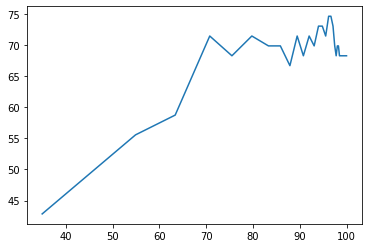

In [32]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
listaPorInf = [] # lista para almancenar el porcentje de información representado por las diferentes posibilidades
for i in range(1,X_train.shape[1]):
    pca = PCA(n_components=i)
    pca.fit(X_train,y_train)
    X_train_transformed =pca.transform(X_train)
    X_test_transformed =pca.transform(X_test)

    knn = neighbors.KNeighborsClassifier()

    knn.fit(X_train_transformed,y_train)
    prediccionTrain = knn.predict(X_train_transformed)
    prediccionTest = knn.predict(X_test_transformed)

    accTrain = metrics.accuracy_score(y_train,prediccionTrain) * 100
    accTest = metrics.accuracy_score(y_test,prediccionTest) * 100
    listaAccTrain.append(accTrain)
    listaAccTest.append(accTest)
    listaPorInf.append(np.sum(pca.explained_variance_ratio_)*100)
    
plt.plot(listaPorInf,listaAccTest)

In [33]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: round(x, 2), np.array(listaPorInf)[::4])), [34.92, 75.49, 87.89, 93.08, 96.17, 97.78, 98.7, 99.22, 99.54, 99.75, 99.89, 99.96, 99.99, 100.0, 100.0], 'Porcentaje de informacion incorrecto')
Test.assertEquals(list(map(lambda x: round(x, 2), np.array(listaAccTrain)[::4])), [75.17, 86.9, 87.59, 89.66, 86.21, 86.9, 85.52, 85.52, 86.21, 86.21, 86.21, 86.21, 86.21, 86.21, 86.21], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), np.array(listaAccTest)[::4])), [42.86, 68.25, 66.67, 69.84, 74.6, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.
1 test passed.


Del mismo modo que en el caso anterior se puede estudiar la influencia del porcentaje de información total a representar por los componentes principales utilizados. Cread el código necesario para obtener el número de compomentes principales utilizados por los porcentajes de información 0.8, 0.85, 0.9 y 0.95 así como sus rendimientos en train y test. En este caso no hace falta realizar una gráfica.

In [35]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
listaNumPCs = [] # lista para almancenar el número de compomentes principales de cada opción
for i in [0.8,0.85,0.9,0.95]:
    pca = PCA(n_components=i)
    pca.fit(X_train,y_train)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)

    knn = neighbors.KNeighborsClassifier()

    knn.fit(X_train_transformed,y_train)

    prediccionTrain = knn.predict(X_train_transformed)
    prediccionTest = knn.predict(X_test_transformed)

    accTrain = metrics.accuracy_score(y_train,prediccionTrain) * 100
    accTest = metrics.accuracy_score(y_test,prediccionTest) * 100
    
    listaAccTrain.append(accTrain)
    listaAccTest.append(accTest)
    listaNumPCs.append(pca.n_components_)

In [36]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(list(map(lambda x: x, listaNumPCs)), [7, 8, 11, 16], 'Numero de componentes principales incorrecto')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTrain)), [91.03, 88.28, 86.9, 86.9], 'Valores de accuracy en train incorrectos')
Test.assertEquals(list(map(lambda x: round(x, 2), listaAccTest)), [69.84, 69.84, 68.25, 71.43], 'Valores de accuracy en test incorrectos')

1 test passed.
1 test passed.
1 test passed.


Finalmente, algo muy interesante es analizar qué variables influyen más en cada componente principal. PAra ello, lo que se suele realizar es calcular la correlación entre las nuevas variables creadas por PCA (los valores de los ejemplos tras realizar la transformación) y las variables originales. Por ejemplo, para analizar las variables que más influyen al primer componente principal (PC1) deberemos realizar la correlación entre los valores de todos los ejemplos tras realizar la transformación con el PC1 y los valores de todos los ejemplos con cada variable original. De este modo, si una variable tiene correlación positiva el valor del PC1 crecerá conforme crezca dicha variable y decrecerá en caso de correlación negativa. Este hecho se puede mostrar muy fácilmente relizando una gráfica con el comando *plot*.

Para realizar la correlación entre las variables se puede utilizar la función [*corrcoef*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) de Numpy. En este caso, la matiz de entrada tiene tantas filas como variables a calcular su correlación y tantas columnas como ejemplos.

En la siguiente celda vamos a analizar la influencia de las variables originales en los componentes principales obtenidos al mantener el 95% de la información.

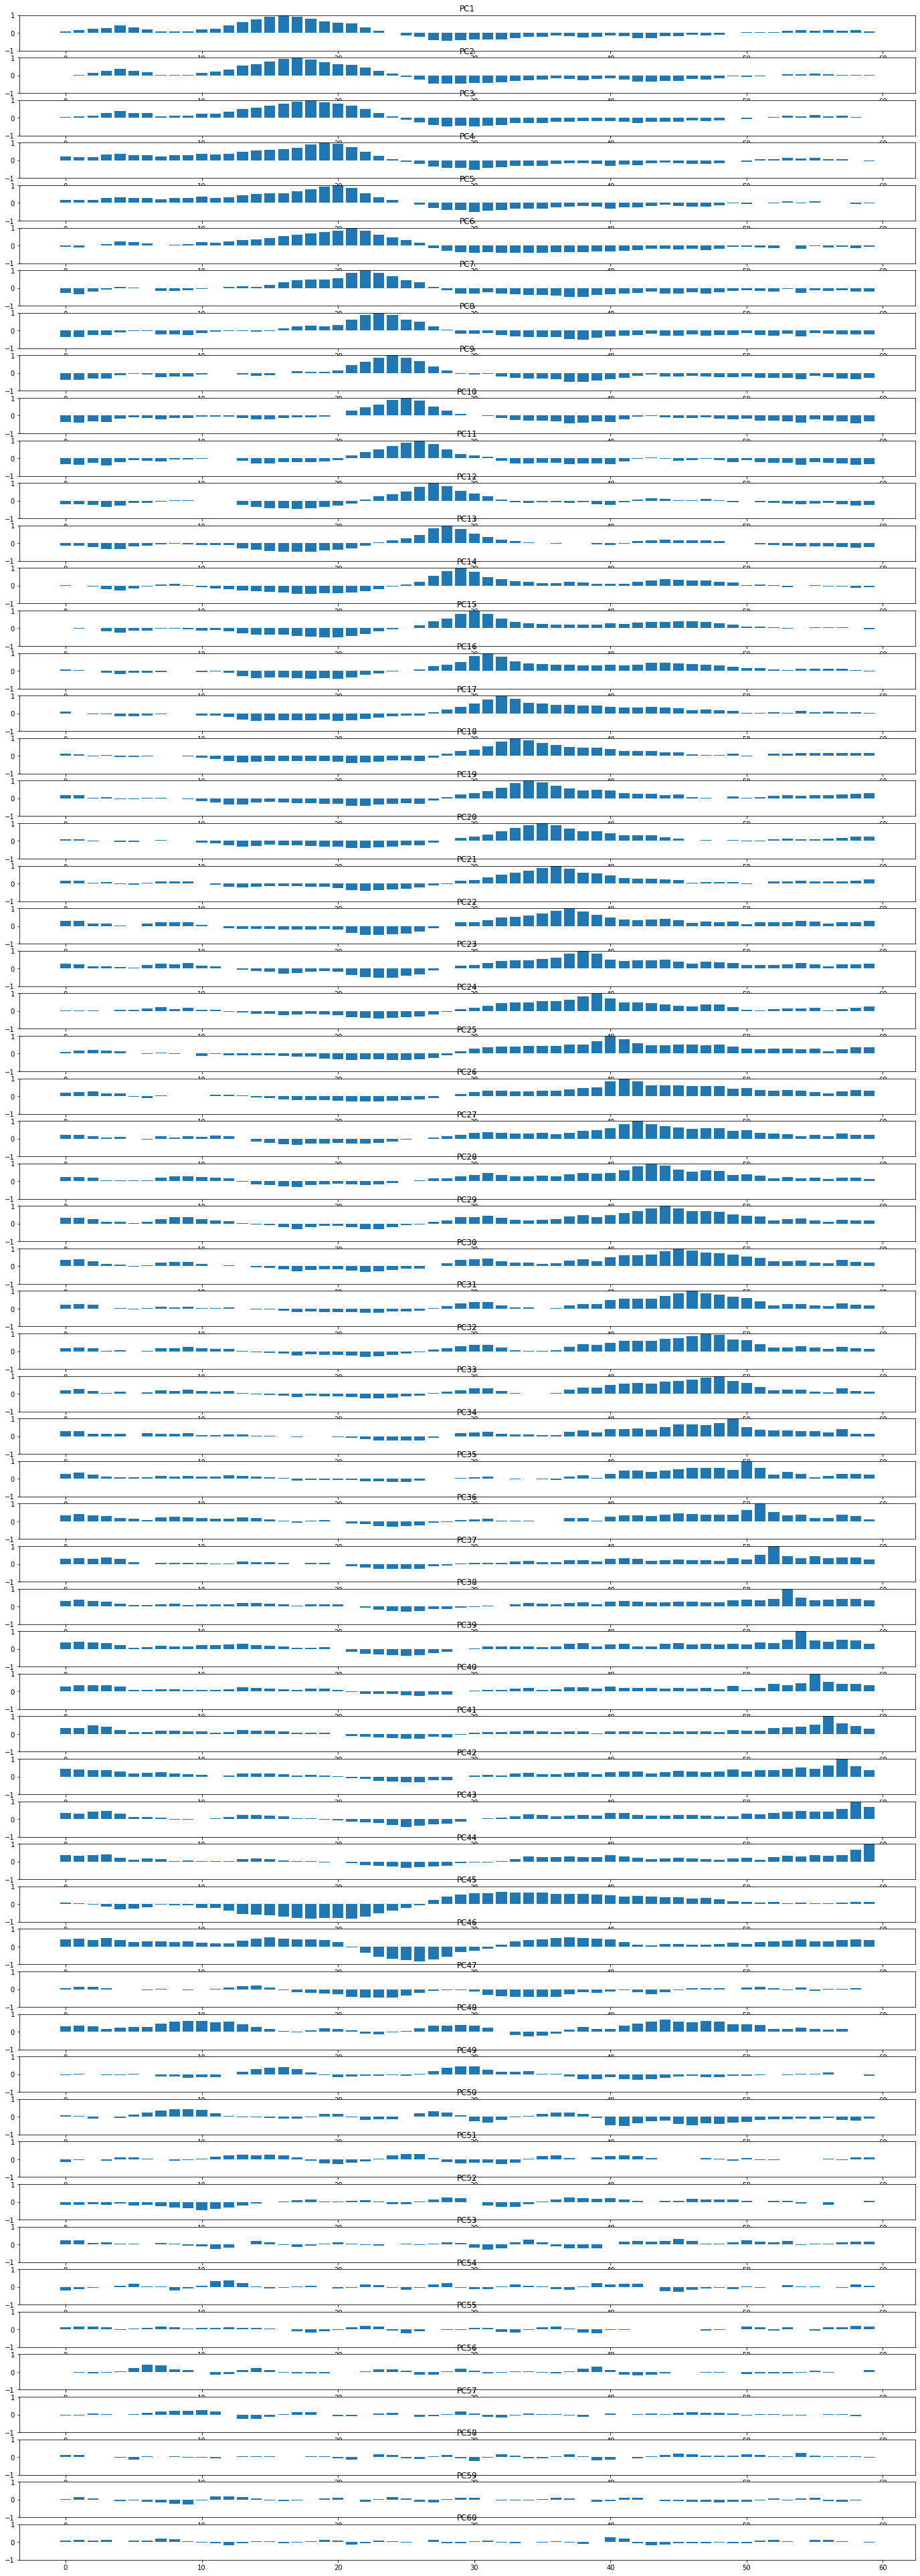

In [37]:
# Obtener los componentes principales de PCA utiliando X_train para entrenar el modelo y transformar los datos
PCA = PCA(n_components=0.95)
PCA.fit(X_train)
X_train_seleccion = PCA.transform(X_train)

# Concatenar verticalmente las matrices de ejemplos originales y transformados en ese orden (transpuestas para que las variables sean las filas)
variablesConPCs = np.vstack((np.transpose(X_train),np.transpose(X_train_seleccion)))
# Obtener la matriz de correlaciones
correlacionesPCs = np.corrcoef(variablesConPCs)
# Seleccionar las últimss n_components_ filas y las X_train.shape[1] primeras columnas
corrPCsVars = correlacionesPCs[pca.n_components_:,:X_train.shape[1]]

# Figura que muestra la influencia de las variables originales en cada componente principal
fig = plt.figure(1, figsize=(24,70))
for i in range(corrPCsVars.shape[0]):
    fig.add_subplot(corrPCsVars.shape[0],1,i+1)
    plt.title("PC"+str(i+1))
    plt.ylim([-1,1])
    plt.bar(range(corrPCsVars.shape[1]),corrPCsVars[i,:])
plt.show()

Realizar una Pipeline que combine:
* Selección de variables utilizando el filtro de ANOVA en base al percentil (seleccionar el 30% de las variables) 
    * feature_selection.SelectPercentile(feature_selection.f_classif, percentile=30)
* Clasificador KNN
    * neighbors.KNeighborsClassifier()

Para ello, utiliza los conjuntos de entrenamiento y test generados al comienzo de la práctica utilizando Hold-out.

Comprueba que los resultados son los mismos que los obtenidos cuando hemos utilizado por separado ambos objetos.

In [38]:
# Se importa la librería pipeline
from sklearn import pipeline

# Se crea la Pipeline con las fases deseadas
pipe = pipeline.Pipeline([('filtroANOVA', feature_selection.SelectPercentile(feature_selection.f_classif, percentile=30)), ('clasificadorKNN', neighbors.KNeighborsClassifier())])
# Se realiza el aprendizaje de los parámetros de todas las fases de la Pipeline
pipe.fit(X_train,y_train)
# Se llama a la predicción de la pipeline sobre los datos de entrenamiento
prediccionesTrain =  pipe.predict(X_train)
# Se calcula el accuracy para los datos de entrenamiento (entre 0.0 y 100.0)
accTrain =  metrics.accuracy_score(y_train,prediccionesTrain)*100
print('Resultado en entrenamiento: {}%'.format(accTrain))
# Se llama a la predicción de la pipeline sobre los datos de test
prediccionesTest = pipe.predict(X_test)
# Se calcula el accuracy para los datos de test (entre 0.0 y 100.0)
accTest = metrics.accuracy_score(y_test,prediccionesTest)*100
print('Resultado en test: {}%'.format(accTest))

Resultado en entrenamiento: 86.89655172413792%
Resultado en test: 88.88888888888889%


In [39]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(round(accTrain, 2), 86.90, 'Valor de accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 88.89, 'Valor de accuracy en test incorrecto')

1 test passed.
1 test passed.


Realizar una Pipeline que combine el filtro ANOVA anterior, el clasificador KNN y además realice en primer lugar la normalización de datos utilizando el método de los mínimos y los máximos:
    * preprocessing.MinMaxScaler()

NOTA: recodar que hay que importar la librería preprocessing

In [41]:
# Se importa la librería de pre-procesamiento para hacer la normalización
from sklearn import preprocessing

# Se crea la Pipeline con las fases deseadas
pipe = pipeline.Pipeline([('normalizacion',preprocessing.MinMaxScaler()),('filtroANOVA', feature_selection.SelectPercentile(feature_selection.f_classif, percentile=30)), ('clasificadorKNN', neighbors.KNeighborsClassifier())])
# Se realiza el aprendizaje de los parámetros de todas las fases de la Pipeline
pipe.fit(X_train,y_train)
# Se llama a la predicción de la pipeline sobre los datos de entrenamiento
prediccionesTrain = pipe.predict(X_train)
# Se calcula el accuracy para los datos de entrenamiento (entre 0.0 y 100.0)
accTrain =  metrics.accuracy_score(y_train,prediccionesTrain)*100
print('Resultado en entrenamiento: {}%'.format(accTrain))
# Se llama a la predicción de la pipeline sobre los datos de test
prediccionesTest =  pipe.predict(X_test)
# Se calcula el accuracy para los datos de test (entre 0.0 y 100.0)
accTest =  metrics.accuracy_score(y_test,prediccionesTest)*100
print('Resultado en test: {}%'.format(accTest))

Resultado en entrenamiento: 85.51724137931035%
Resultado en test: 85.71428571428571%


In [42]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
Test.assertEquals(round(accTrain, 2), 85.52, 'Valor de accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 85.71, 'Valor de accuracy en test incorrecto')

1 test passed.
1 test passed.


Utiliza la clase GridSearchCV para buscar la configuración óptima de la Pipeline compuesta por el filtro ANOVA y el clasificador KNN (sin normalización). Los híper-parámetros y sus valores son:
* Para la selección de variables basado en el percentil y el filtro ANOVA
    * percentile: 10, 20, 30
* Para el clasificador KNN
    * n_neighbors: 1, 3, 5, 7, 9
    * weights: ‘uniform’, ‘distance’
    * p: [1, 2, 1.5, 3]

NOTAS:
* Llamad al componente del filtro Anova *filtroANOVA* y al clasificador KNN *KNN*.
* Utiliza 10 particiones y el accuracy para realizar la validación cruzada.

In [43]:
from sklearn import model_selection

# Se crea la Pipeline con las fases deseadas
pipe = pipeline.Pipeline([('filtroANOVA', feature_selection.SelectPercentile(feature_selection.f_classif)), ('KNN', neighbors.KNeighborsClassifier())])
# Se crea el grid de híper-parámetros
parameters =  {'filtroANOVA__percentile':[10, 20 ,30], 'KNN__n_neighbors':[1, 3, 5, 7, 9], 'KNN__weights': ['uniform','distance'], 'KNN__p': [1,2, 1.5 ,3]}
# Se llama al constructor de GridSearchCV para que genere todas las combinaciones de los híper-parámetros definidos anteriormente
gridSearch_pipe = model_selection.GridSearchCV(pipe, parameters, n_jobs=-1, cv=10)
# Se realiza el aprendizaje de todos los clasificadores considerados (todas las configuraciones)
gridSearch_pipe.fit(X_train,y_train)
# Se muestra la mejor configuración junto con su rendimiento
print(gridSearch_pipe.best_score_)
print(gridSearch_pipe.best_params_)


# Almacenamos el DataFrame con los resultados
diccionarioResultados = pd.DataFrame(gridSearch_pipe.cv_results_)

# Se imprime el mejor porcentaje de acierto y los resultados de todas las configuraciones
print(gridSearch_pipe.best_score_)
print(gridSearch_pipe.best_params_)

# Se obtiene el rendimiento en entrenamiento y test por la mejor configuración
prediccionesTrain = gridSearch_pipe.predict(X_train)
prediccionesTest = gridSearch_pipe.predict(X_test)
accTrain = metrics.accuracy_score(y_train,prediccionesTrain)*100
accTest = metrics.accuracy_score(y_test,prediccionesTest)*100
print(accTrain,accTest)

0.8285714285714285
{'KNN__n_neighbors': 1, 'KNN__p': 2, 'KNN__weights': 'uniform', 'filtroANOVA__percentile': 30}
0.8285714285714285
{'KNN__n_neighbors': 1, 'KNN__p': 2, 'KNN__weights': 'uniform', 'filtroANOVA__percentile': 30}
100.0 84.12698412698413


In [44]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(accTrain, 2), 100.00, 'Valor de accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 84.13, 'Valor de accuracy en test incorrecto')

1 test passed.
1 test passed.


In [45]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados['mean_test_score'])
Test.assertEquals(round(np.max(diccionarioResultados['mean_test_score']), 4), 0.8286, "Accuracy de la mejor configuración incorrecto")
Test.assertEquals(diccionarioResultados['params'][indice], {'KNN__n_neighbors': 1, 'KNN__p': 2, 'KNN__weights': 'uniform', 'filtroANOVA__percentile': 30}, "Mejor configuración incorrecta")

1 test passed.
1 test passed.


/home/wyryby/anaconda3/envs/py37machlearn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Crea una Pipeline que aplique el filtro t_test que hemos implementado utilizando la selección de las K mejores variables y el clasificador de los K vecinos más cercanos. Obtened la mejor configuración de dicha Pipeline al examinar los mismos valores que en el caso anterior para KNN y los valores 10, 20 y 30 para el filtro t_test.

NOTAS:
* Llamad al componente del filtro t_test *t_test* y al clasificador KNN *KNN*.

In [47]:
# Se crea la Pipeline con las fases deseadas
pipe = pipeline.Pipeline([('t_test', t_test(tipoSeleccion='Kbest',K=numVar)), ('KNN', neighbors.KNeighborsClassifier())])
# Se crea el grid de híper-parámetros
parameters =  {'t_test__tipoSeleccion':['Kbest'],'t_test__K':[10, 20 ,30], 'KNN__n_neighbors':[1, 3, 5, 7, 9], 'KNN__weights': ['uniform','distance'], 'KNN__p': [1,2, 1.5 ,3]}
# Se llama al constructor de GridSearchCV para que genere todas las combinaciones de los híper-parámetros definidos anteriormente
gridSearch_pipe = model_selection.GridSearchCV(pipe, parameters, cv=10)
# Se realiza el aprendizaje de todos los clasificadores considerados (todas las configuraciones)
gridSearch_pipe.fit(X_train,y_train)
# Se muestra la mejor configuración junto con su rendimiento
print(gridSearch_pipe.best_score_)
print(gridSearch_pipe.best_params_)


# Almacenamos el DataFrame con los resultados
diccionarioResultados = pd.DataFrame(gridSearch_pipe.cv_results_)

# Se imprime el mejor porcentaje de acierto y los resultados de todas las configuraciones
print(gridSearch_pipe.best_score_)
print(gridSearch_pipe.best_params_)

# Se obtiene el rendimiento en entrenamiento y test por la mejor configuración
prediccionesTrain = gridSearch_pipe.predict(X_train)
prediccionesTest = gridSearch_pipe.predict(X_test)
accTrain = metrics.accuracy_score(y_train,prediccionesTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionesTest)*100

0.8471428571428572
{'KNN__n_neighbors': 1, 'KNN__p': 3, 'KNN__weights': 'uniform', 't_test__K': 30, 't_test__tipoSeleccion': 'Kbest'}
0.8471428571428572
{'KNN__n_neighbors': 1, 'KNN__p': 3, 'KNN__weights': 'uniform', 't_test__K': 30, 't_test__tipoSeleccion': 'Kbest'}


In [48]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(accTrain, 2), 100.00, 'Valor de accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 85.71, 'Valor de accuracy en test incorrecto')

1 test passed.
1 test passed.


In [49]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados['mean_test_score'])
Test.assertEquals(round(np.max(diccionarioResultados['mean_test_score']), 4), 0.8471, "Accuracy de la mejor configuración incorrecto")
Test.assertEquals(diccionarioResultados['params'][indice], {'KNN__n_neighbors': 1, 'KNN__p': 3, 'KNN__weights': 'uniform', 't_test__K': 30}, "Mejor configuración incorrecta")

1 test passed.
1 test failed. Mejor configuración incorrecta


/home/wyryby/anaconda3/envs/py37machlearn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Exception: Mejor configuración incorrecta

Crea una Pipeline que aplique PCA utilizando 'full' como valor del parámetro *svd_solver* y el clasificador de los K vecinos más cercanos. Obtened la mejor configuración de dicha Pipeline al examinar los mismos valores que en el caso anterior para KNN y los valores 0.85, 0.88, 0.92, 0.95 y 0.97 como porcentaje de información a mantener al aplicar PCA.

NOTAS:
* Llamad al componente de PCA *pca* y al clasificador KNN *KNN*.

In [56]:
from sklearn.decomposition import PCA
# Se crea la Pipeline con las fases deseadas
clf_compuestoPCA = pipeline.Pipeline([('pca', PCA(svd_solver='full')), ('KNN', neighbors.KNeighborsClassifier())])
# Se crea el grid de parámetros a "optimizar"
parameters = {'pca__n_components':[0.85, 0.88 ,0.92, 0.95, 0.97],  'KNN__n_neighbors':[1, 3, 5, 7, 9], 'KNN__weights': ['uniform','distance'], 'KNN__p': [1,2, 1.5 ,3]}
# Se llama al constructor de GridSearchCV para que genere todas las combinaciones ce los parámetros definidos anteriormente
gridSearch_pipe = model_selection.GridSearchCV(clf_compuestoPCA, parameters, n_jobs=-1, cv=10)
# Se realiza el aprendizaje de todos los clasificadores considerados (todas las configuraciones)
gridSearch_pipe.fit(X_train,y_train)
# Se muestra la mejor configuración junto con su rendimiento

diccionarioResultados = pd.DataFrame(gridSearch_pipe.cv_results_)

prediccionesTrain = gridSearch_pipe.predict(X_train)
prediccionesTest = gridSearch_pipe.predict(X_test)
accTrain = metrics.accuracy_score(y_train,prediccionesTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionesTest)*100

In [57]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(accTrain, 2), 100.00, 'Valor de accuracy en train incorrecto')
Test.assertEquals(round(accTest, 2), 76.19, 'Valor de accuracy en test incorrecto')

1 test passed.
1 test passed.


In [58]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados['mean_test_score'])
Test.assertEquals(round(np.max(diccionarioResultados['mean_test_score']), 4), 0.8438, "Accuracy de la mejor configuración incorrecto")
Test.assertEquals(diccionarioResultados['params'][indice], {'KNN__n_neighbors': 3, 'KNN__p': 3, 'KNN__weights': 'distance', 'pca__n_components': 0.88}, "Mejor configuración incorrecta")

1 test passed.
1 test passed.


/home/wyryby/anaconda3/envs/py37machlearn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
